Python has a wonderful open-source library for performing NLP (natural language processing) on text. This library is called the <i>Natural Language Toolkit</i> (NLTK). This article is written for <i>NLTK v3.0.5</i>. NLTK gives you many features out-of-the-box. For example, you can obtain parts-of-speech (POS) tags of words in a sentence with the following code:

In [1]:
import nltk
sentence = 'This is a sentence.'
tokens = nltk.word_tokenize(sentence)
tagged_tokens = nltk.pos_tag(tokens)
print(tagged_tokens)

[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('sentence', 'NN'), ('.', '.')]


The focus of this writing, is the NLTK's NE (named entity) chunker, which I will abbreviate as a <i>NEC</i>. A named entity is something like <b>Wal-Mart</b>, <b>Virginia</b>, or <b>Barack Obama</b>.
</p>

What a named entity is not, is something like <b>store</b>, <b>walked</b>, or <b>saw</b>. The definition of a chunk is a substring of text which cannot overlap another chunk. Consider the following sentence:

<code>President Barack Obama is the 44th President of the United States of America.</code>

In this example, you'll never end up receiving a chunk of <b>Obama</b> <i>and</i> <b>Barack Obama</b>. Can't happen--because in this example they would overlap. So the process of NE chunking, is identifying chunks in text which are NEs. Let's demonstrate the NLTK's NEC in action:

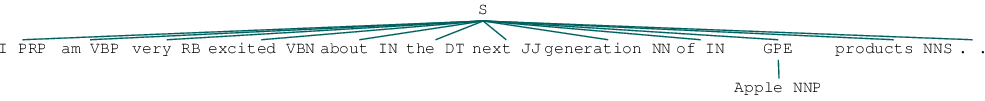

In [2]:
tokens = nltk.word_tokenize('I am very excited about the next generation of Apple products.')
tokens = nltk.pos_tag(tokens)
tree = nltk.ne_chunk(tokens)
tree

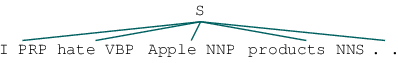

In [3]:
tokens = nltk.word_tokenize('I hate Apple products.')
tokens = nltk.pos_tag(tokens)
tree = nltk.ne_chunk(tokens)
tree

These examples are chosen for a reason. Notice in both examples, the word <i>Apple</i> was POS tagged as <b>NNP</b> (NNP is the UPenn TreeBank II for a proper, singular noun). Also, both words begin with upper-case letters. So why did the NEC tag Apple as a NE in the first example, but not the second? Also, why did Apple get tagged as a GPE (geo-political entity)?

<h1>Machine Learning</h1>
The NLTK's NEC works by using a supervised machine learning algorithm known as a <b>MaxEnt classifier</b>. A MaxEnt classifier gets its name from <i>maximum entropy</i>. For a <i>discrete</i> probability distribution, maximum entropy is obtained when the distribution is uniform. A MaxEnt classifier is logistic regression. The difference is theoretical, because in the MaxEnt derivation, you assume maximum entropy and derive the sigmoid function. In the logistic regression derivation, you assume the sigmoid function. <a href="#ref1">[J. Mount]</a>.
<p>
This machine learning model uses data from a corpus that has been manually annotated for NEs. A person, called an <b>annotator</b>, will read sentence after sentence and manually mark where the NEs are found in text. This is of course, a very tedious task. It is no wonder that most annotated corpora are not distributed for free. In fact, the NLTK does not provide you with the corpora it trained the NEC on (it was trained on data from ACE--Automatic Content Extraction). What the authors did provide, however, was a pickle file (a python serialized object) trained on this data. This pickle file, is a freeze-dried instance of the statistics needed for the MaxEnt classifier.
<p>
A note I'd like to add, is that the NLTK does provide NE annotated data found in corpora/ieer. However, unless that data is a good representation of the data you want to classify on, I wouldn't recommend using it. Also, you will have to write your own feature extractor for this, because the format in IEER is different than ACE.

<h1>Features</h1>
The task of building a good supervised ML is identifying which features will work best. A feature is something you will compute statistics on. In NER, for example, one feature could be whether the word contains an upper-case letter (note: for Twitter data, this could be a bad feature). So what features are used in NLTK's NEC? I've listed them below:

<ul>
<li>
The shape of the word (e.g., does it contain numbers? does it begin with a capital letter?)
<li>
The length of the word
<li>
The first three letters of the word
<li>
The last three letters of the word
<li>
The POS tag of the word
<li>
The word itself
<li>
Does the word exist in an English dictionary?
<li>
The tag of the word that precedes this word (i.e., was the previous word identified as a NE)
<li>
The POS tag of the preceding word
<li>
The POS tag of the following word
<li>
The word that precedes this word
<li>
The word that follows this word
<li>
The word combined with the POS tag of the following word
<li>
The POS tag of the word combined with the tag of the preceding word
<li>
The shape of the word combined with the tag of the preceding word
</ul>
<h1>Lifting the Hood</h1>
As you can see, the list is long and will be hard to intuitively guess how the NEC will behave in different situations. To lift the hood on this, I've written some code using methods available in the NLTK to gain insight on why the NEC performs the way it does on different sentences:


In [4]:
# Loads the serialized NEChunkParser object
chunker = nltk.data.load('chunkers/maxent_ne_chunker/english_ace_multiclass.pickle')

# The MaxEnt classifier
maxEnt = chunker._tagger.classifier()

def maxEnt_report():
    maxEnt = chunker._tagger.classifier()
    print("These are the labels used by the NLTK\'s NEC:\n")
    print(maxEnt.labels())
    print("These are the most informative features found in the ACE corpora:\n")
    print(maxEnt.show_most_informative_features())

def ne_report(sentence, report_all=False):
    tokens = nltk.word_tokenize(sentence)
    tagged_tokens = nltk.pos_tag(tokens)
    tags = []
    for i in xrange(len(tagged_tokens)):
        featureset = chunker._tagger.feature_detector(tagged_tokens, i, tags)
        tag = chunker._tagger.choose_tag(tagged_tokens, i, tags)
        if tag != 'O' or report_all:
            print '\nExplanation on the why the word \'' + tagged_tokens[i][0] + '\' was tagged:'
            featureset = chunker._tagger.feature_detector(tagged_tokens, i, tags)
            maxEnt.explain(featureset)
        tags.append(tag)

The first function, <code>maxEnt_report()</code>, just displays information specific to the MaxEnt classifier. Here's how it works. If you execute:

In [5]:
maxEnt_report()

These are the labels used by the NLTK's NEC:

['I-GSP', 'B-LOCATION', 'B-GPE', 'I-ORGANIZATION', 'I-PERSON', 'O', 'I-FACILITY', 'I-LOCATION', 'B-PERSON', 'B-FACILITY', 'B-GSP', 'B-ORGANIZATION', 'I-GPE']
These are the most informative features found in the ACE corpora:

  10.125 bias==True and label is 'O'
   6.631 suffix3=='day' and label is 'O'
  -6.207 bias==True and label is 'I-GSP'
   5.628 prevtag=='O' and label is 'O'
  -4.740 shape=='upcase' and label is 'O'
   4.106 shape+prevtag=='<function shape at 0x8bde0d4>+O' and label is 'O'
  -3.994 shape=='mixedcase' and label is 'O'
   3.992 pos+prevtag=='NNP+B-PERSON' and label is 'I-PERSON'
   3.890 prevtag=='I-ORGANIZATION' and label is 'I-ORGANIZATION'
   3.879 shape+prevtag=='<function shape at 0x8bde0d4>+I-ORGANIZATION' and label is 'I-ORGANIZATION'
None


The first paragraph reports the labels used in the NLTK's NEC. The 'I-', 'O', and 'B-' prefixes require some explaining. These come from a form of tagging known as IOB (inside, outside, and begin) tagging. When a chunk begins, the first word is prefixed with a 'B' to indicate this word is the beginning of a chunk. The next word, if it belongs to the same chunk, would be prefixed with 'I' to indicate it's part of the chunk, but not the beginning. If a word does not belong to a chunk, it is labeled as 'O', meaning it is outside. The purpose of this notation is to satisfy the definition of a chunk.

Here's how the next method works:

In [6]:
ne_report('I am very excited about the next generation of Apple products.')


Explanation on the why the word 'Apple' was tagged:
  Feature                                            B-GPE       O B-ORGAN   B-GSP
  --------------------------------------------------------------------------------
  prevtag=='O' (1)                                   3.767
  shape=='upcase' (1)                                2.701
  pos+prevtag=='NNP+O' (1)                           2.254
  en-wordlist==False (1)                             2.095
  label is 'B-GPE' (1)                              -2.005
  bias==True (1)                                    -1.975
  prevword=='of' (1)                                 0.742
  pos=='NNP' (1)                                     0.681
  nextpos=='nns' (1)                                 0.661
  prevpos=='IN' (1)                                  0.311
  wordlen==5 (1)                                     0.113
  nextword=='products' (1)                           0.060
  bias==True (1)                                            10.125
  prev

It outputs only explanations for words that we tagged as a NE (if you want output for all words, regardless of whether it is a NE, set the second argument to True) I want to point out something here. The probabilities listed in the final row do not add up to one (they add up to ~0.89). This is because the output only displays the top four candidate labels.

Try to run this on the sentence:

<code>I hate Apple products</code>

and see if you can identify the features which caused it to miss being tagged.

<h1>References</h1>
<p>
<a id="ref1"></a>[1] J. Mount, <a href="http://www.win-vector.com/dfiles/LogisticRegressionMaxEnt.pdf">The equivalence of logistic regression and maximum entropy models</a>